### H(z) Reconstrution via Gaussian Process (GP)

 /home/lazarolima/.local/lib/python3.12/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply


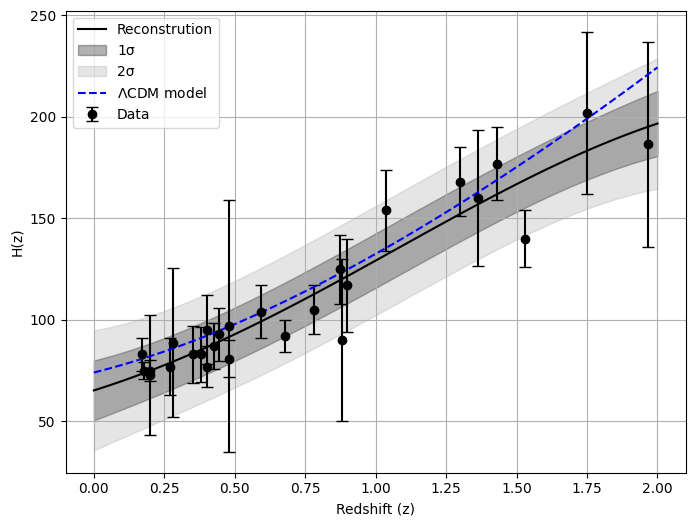

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gaussian_process as gp
from obs_data import H_data
from equations import FiducialModel

fiducial_model = FiducialModel()

z_values = H_data.z_func()
H_obs = H_data.H_func()
errors = H_data.errors_func()

# Obter valores de predição
mean, var, mean_deriv, var_deriv = gp.pred()

# Modelo LambdaCDM plano
z_test = gp.z_pred()
H_theory = fiducial_model.H_padrao(z_test.flatten())

# Plotar os resultados
plt.figure(figsize=(8, 6))

# Dados originais com barras de erro
plt.errorbar(z_values, H_obs, yerr=errors, fmt='o', capsize=4, color='k', label='Data')

# Função predita pelo GP
plt.plot(z_test, mean, 'k-', label='Reconstrution')

# Adicionar curvas sombreadas de 1σ e 2σ
plt.fill_between(z_test.flatten(), 
                 mean.flatten() - 1*np.sqrt(var.flatten()), 
                 mean.flatten() + 1*np.sqrt(var.flatten()), 
                 alpha=0.3, color='k', label='1σ')
plt.fill_between(z_test.flatten(), 
                 mean.flatten() - 2*np.sqrt(var.flatten()), 
                 mean.flatten() + 2*np.sqrt(var.flatten()), 
                 alpha=0.2, color='gray', label='2σ')

plt.plot(z_test, H_theory, 'b--', label='$\\Lambda$CDM model')

plt.xlabel('Redshift (z)')
plt.ylabel('H(z)')
plt.legend()
plt.grid(True)
plt.savefig('Figuras/H_reconstructed.png', dpi=600)


### H(z) Reconstrution via Artificial Neural Network (ANN): ReFANN code

FcNet(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Linear(in_features=4096, out_features=2, bias=True)
  )
)

Training the network using CPU
(iteration:2000/30000; loss:0.37163; lr:0.03414549)
(iteration:4000/30000; loss:0.15487; lr:0.01165914)
(iteration:6000/30000; loss:0.19295; lr:0.00398107)
(iteration:8000/30000; loss:0.17561; lr:0.00135936)
(iteration:10000/30000; loss:0.13442; lr:0.00046416)
(iteration:12000/30000; loss:0.16995; lr:0.00015849)
(iteration:14000/30000; loss:0.17041; lr:0.00005412)
(iteration:16000/30000; loss:0.18465; lr:0.00001848)
(iteration:18000/30000; loss:0.17820; lr:0.00000631)
(iteration:20000/30000; loss:0.17132; lr:0.00000215)
(iteration:22000/30000; loss:0.18348; lr:0.00000074)
(iteration:24000/30000; loss:0.14293; lr:0.00000025)
(iteration:26000/30000; loss:0.22221; lr:0.00000009)

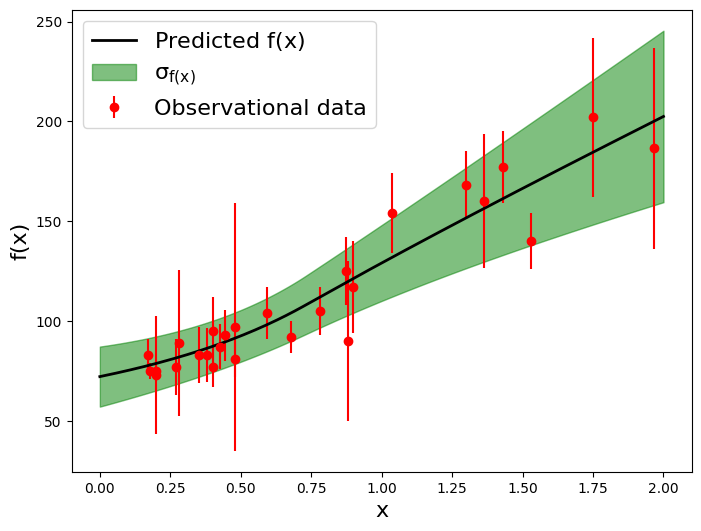

In [2]:
import refann as rf
import time
from obs_data import H_data

# Obter os dados
z = H_data.z_func()
H = H_data.H_func()
errors = H_data.errors_func()

# Salvar em arquivo.txt
with open('data/H_obs.txt', 'w') as file:
    for z_val, H_val, error in zip(z, H, errors):
        file.write(f"{z_val}\t{H_val}\t{error}\n")

# Starting the ANN
start_time = time.time()

Hz = np.loadtxt('data/H_obs.txt')

rec = rf.ANN(Hz,mid_node=4096,hidden_layer=1,hp_model='rec_2')
rec.iteration = 30000
rec.train()
func = rec.predict(xpoint=np.linspace(0, 2, 201))
#func = rec.predict(xspace=(0, 2, 201)) #or use this
rec.save_func(path='data', obsName='Hz31') #save the reconstructed function

# rec.plot_loss()
rec.plot_func()


print ("Time elapsed: %.3f mins" %((time.time()-start_time)/60))
plt.show()

# Generating FRBs Mock data

In [3]:
from mock import RedshiftSimulation

# Parâmetros para gerar novos dados
n_new = 300  # Número de novos pontos de dados
z_max = 2  # Máximo redshift

# Criar uma instância da classe RedshiftSimulation
sim = RedshiftSimulation(n_new, z_max)

# Gerar novos dados
sim.generate_redshifts()
sim.simulate_DM_IGM()
sim.sigma_DM_IGM_sim()

# Obter os resultados
new_z = sim.get_new_z()
DM_IGM_sim = np.abs(sim.get_DM_IGM_sim())
sigma_DM_IGM_sim = sim.get_sigma_DM_IGM_sim()

# Salvar em arquivo.txt
with open('data/DM_IGM_sim.txt', 'w') as file:
    for z, dm, sigma in zip(new_z, DM_IGM_sim, sigma_DM_IGM_sim):
        file.write(f"{z}\t{dm}\t{sigma}\n")

#### DM_IGM reconstruction throught GP

 /tmp/ipykernel_7593/1693721478.py:7: UserWarning:color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
 /tmp/ipykernel_7593/1693721478.py:8: UserWarning:color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.


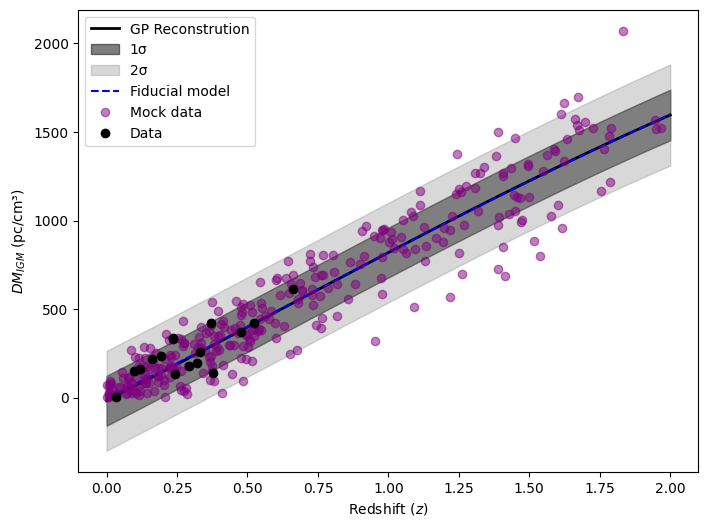

In [4]:
import obs_data as od

# Plotar os resultados
plt.figure(figsize=(8, 6))

# Dados originais com barras de erro
plt.errorbar(new_z, DM_IGM_sim, fmt='ro', color='purple', alpha=0.5, label='Mock data')
plt.errorbar(od.z_obs, od.DM_IGM_obs, fmt='ro', color='k', alpha=1, label='Data')

# Obter valores de predição
mean1, var1, mean_deriv1, var_deriv1 = gp.pred_new()

# Função predita pelo GP
plt.plot(gp.z_pred(), mean1, 'k-', label='GP Reconstrution', lw=2)

# Adicionar curvas sombreadas de 1σ e 2σ
plt.fill_between(gp.z_pred().flatten(), 
                 mean1.flatten() - 1*np.sqrt(var1.flatten()), 
                 mean1.flatten() + 1*np.sqrt(var1.flatten()), 
                 alpha=0.5, color='k', label='1σ')
plt.fill_between(gp.z_pred().flatten(), 
                 mean1.flatten() - 2*np.sqrt(var1.flatten()), 
                 mean1.flatten() + 2*np.sqrt(var1.flatten()), 
                 alpha=0.3, color='gray', label='2σ')

# Modelo fiducial
# Create an instance of the model
from equations import FiducialModel

model = FiducialModel()

dm_igm_theory = model.DM_IGM(gp.z_pred().flatten())
plt.plot(gp.z_pred(), dm_igm_theory, 'b--', label='Fiducial model')

plt.xlabel('Redshift ($z$)')
plt.ylabel('$DM_{IGM}$ (pc/cm³)')
plt.legend()
plt.savefig('Figuras/DM_IGM_reconstructed.png', dpi=600)

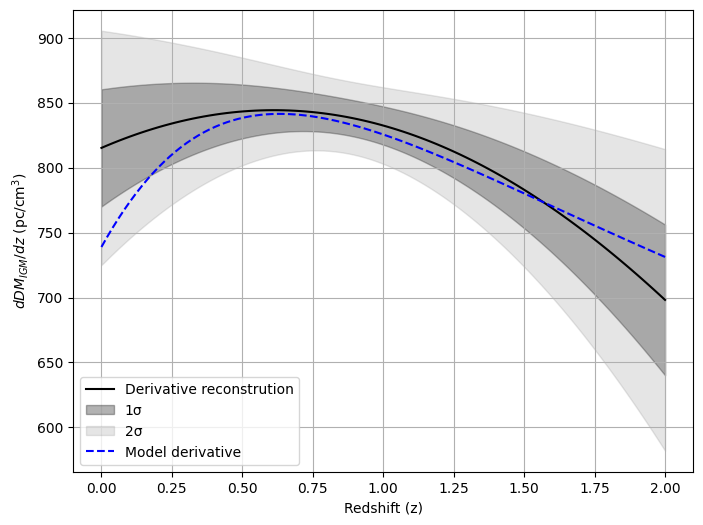

In [5]:
# Obter valores de predição
mean1, var1, mean_deriv1, var_deriv1 = gp.pred_new()

# Plotar as derivadas
plt.figure(figsize=(8, 6))
plt.plot(gp.z_pred(), mean_deriv1.flatten(), 'k-', label='Derivative reconstrution')

# Adicionar curvas sombreadas de 1σ e 2σ para a derivada
plt.fill_between(gp.z_pred().flatten(), 
                 mean_deriv1.flatten() - 1*np.sqrt(var_deriv1.flatten()), 
                 mean_deriv1.flatten() + 1*np.sqrt(var_deriv1.flatten()), 
                 alpha=0.3, color='k', label='1σ')
plt.fill_between(gp.z_pred().flatten(), 
                 mean_deriv1.flatten() - 2*np.sqrt(var_deriv1.flatten()), 
                 mean_deriv1.flatten() + 2*np.sqrt(var_deriv1.flatten()), 
                 alpha=0.2, color='gray', label='2σ')

# Derivada de DM_IGM
dm_igm_deriv = model.I(gp.z_pred().flatten())
plt.plot(gp.z_pred().flatten(), dm_igm_deriv, 'b--', label='Model derivative')

plt.xlabel('Redshift (z)')
plt.ylabel('$dDM_{IGM}/dz$ (pc/cm$^{3}$)')
plt.legend()
plt.grid(True)
plt.savefig('Figuras/dDM_IGM_reconstructed.png', dpi=600)

#### DM_IGM reconstruction throught ANN

In [ ]:
DM_IGM = np.loadtxt('data/DM_IGM_sim.txt')

rec = rf.ANN(DM_IGM,mid_node=4096,hidden_layer=1,hp_model='rec_2')
rec.iteration = 30000
rec.train()
func = rec.predict(xpoint=np.linspace(0, 2, 201))
#func = rec.predict(xspace=(0, 2, 201)) #or use this
rec.save_func(path='data', obsName='DM_IGM') #save the reconstructed function

# rec.plot_loss()
rec.plot_func()


print ("Time elapsed: %.3f mins" %((time.time()-start_time)/60))
plt.show()

# Bayesian analyses and MCMC

### Defining priors

In [6]:
from likelihood import Priors, LikelihoodFunction
from equations import H_Model

model = H_Model()

# Defining the prior intervals manually
intervals_constant = [(0, 1)]  # Interval for $f_{IGM}$
intervals_p2 = [(0, 1), (0, 5)]  # Intervals for $f_{IGM}$ and $\alpha$
intervals_p3 = [(0, 1), (0, 5)]  # Intervals for $f_{IGM}$ and $\alpha$
intervals_p4 = [(0, 1), (-5, 5)]  # Intervals for $f_{IGM}$ and $s$

# Creating specific instances of the priors
P_constant = Priors(['$f_{IGM}$'], intervals_constant)
P_p2 = Priors(['$f_{IGM}$', '$\\alpha$'], intervals_p2)
P_p3 = Priors(['$f_{IGM}$', '$\\alpha$'], intervals_p3)
P_p4 = Priors(['$f_{IGM}$', '$s$'], intervals_p4)

# Creating an instance of the likelihood model
LF_constant = LikelihoodFunction(lambda z, f_IGM: model.H_p(z, f_IGM, None, 'constant'))
LF_p2 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p2'))
LF_p3 = LikelihoodFunction(lambda z, f_IGM, alpha: model.H_p(z, f_IGM, alpha, 'p3'))
LF_p4 = LikelihoodFunction(lambda z, f_IGM, s: model.H_p(z, f_IGM, s, 'p4'))

### Preparing the samples

In [7]:
from obs_data import H_data
import ultranest

z_values = H_data.z_func()
H_obs = H_data.H_func()
errors = H_data.errors_func()
model = H_Model()

# Configuring the ultranest samplers
sampler_constant = ultranest.ReactiveNestedSampler(P_constant.param_names,
    lambda params: LF_constant.log_likelihood(params, z_values, H_obs, errors),
    P_constant.prior_transform
)

sampler_p2 = ultranest.ReactiveNestedSampler(P_p2.param_names,
    lambda params: LF_p2.log_likelihood(params, z_values, H_obs, errors),
    P_p2.prior_transform
)

sampler_p3 = ultranest.ReactiveNestedSampler(P_p3.param_names,
    lambda params: LF_p3.log_likelihood(params, z_values, H_obs, errors),
    P_p3.prior_transform
)

sampler_p4 = ultranest.ReactiveNestedSampler(P_p4.param_names,
    lambda params: LF_p4.log_likelihood(params, z_values, H_obs, errors),
    P_p4.prior_transform
)


In [8]:
result1 = sampler_constant.run(min_num_live_points=400)
sampler_constant.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  00 [-7.9975..-7.9975]*| it/evals=2610/3088 eff=97.0982% N=400     
[ultranest] Likelihood function evaluations: 3111
[ultranest]   logZ = -11.17 +- 0.06326
[ultranest] Effective samples strategy satisfied (ESS = 1262.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.08 bs:0.06 tail:0.03 total:0.07 required:<0.50
[ultranest] done iterating.

logZ = -11.178 +- 0.140
  single instance: logZ = -11.178 +- 0.082
  bootstrapped   : logZ = -11.167 +- 0.136
  tail           : logZ = +- 0.033
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.709 │ ▁ ▁▁▁▁▁▁▁▁▂▃▄▄▅▆▇▇▇▇▇▇▆▅▄▃▃▂▂▁▁▁▁▁▁ ▁ │0.851     0.782 +- 0.018



In [9]:
result2 = sampler_p2.run(min_num_live_points=400)
sampler_p2.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  00 [-8.0350..-8.0350]*| it/evals=4760/6404 eff=79.2805% N=400 00    0 
[ultranest] Likelihood function evaluations: 6407
[ultranest]   logZ = -15.32 +- 0.08547
[ultranest] Effective samples strategy satisfied (ESS = 1690.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -15.324 +- 0.173
  single instance: logZ = -15.324 +- 0.124
  bootstrapped   : logZ = -15.319 +- 0.172
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.631 │ ▁▁ ▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▅▅▇▇▇▆▆▅▄▃▂▁▁▁▁▁▁▁ │0.847     0.759 +- 0.025
    $\alpha$            : 0.000 │▇▇▇▆▅▅▅▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁   ▁  ▁ │0.432     0.067 +- 0.055



In [11]:
result3 = sampler_p3.run(min_num_live_points=400)
sampler_p3.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  00 [-8.0410..-8.0410]*| it/evals=4440/6120 eff=77.6224% N=400 00    
[ultranest] Likelihood function evaluations: 6126
[ultranest]   logZ = -14.53 +- 0.09206
[ultranest] Effective samples strategy satisfied (ESS = 1714.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -14.533 +- 0.197
  single instance: logZ = -14.533 +- 0.115
  bootstrapped   : logZ = -14.528 +- 0.196
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.583 │ ▁  ▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▇▇▇▇▇▇▆▅▄▂▁▁▁▁  ▁ │0.865     0.749 +- 0.033
    $\alpha$            : 0.00  │▇▇▇▆▅▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁       ▁ │0.81      0.13 +- 0.10



In [12]:
result4 = sampler_p4.run(min_num_live_points=400)
sampler_p4.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  82 [-7.8319..-7.8319]*| it/evals=4840/9054 eff=55.9279% N=400 00    0  00 
[ultranest] Likelihood function evaluations: 9057
[ultranest]   logZ = -15.34 +- 0.1075
[ultranest] Effective samples strategy satisfied (ESS = 1605.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -15.331 +- 0.156
  single instance: logZ = -15.331 +- 0.127
  bootstrapped   : logZ = -15.337 +- 0.155
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.281 │ ▁    ▁▁▁▁▁▁▁▁▂▂▂▄▃▄▆▇▇▆▇▆▆▅▄▃▂▂▁▂▁▁▁▁▁│1.000     0.718 +- 0.088
    $s$                 : -0.627│ ▁           ▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▅▆▇▇▇▅▃▂▁▁ │0.123     -0.044 +- 0.060



In [13]:
from getdist import plots, MCSamples

# Extraindo amostras dos resultados
samples1 = result1['samples']
samples2 = result2['samples']
samples3 = result3['samples']
samples4 = result4['samples']

# Criando objetos MCSamples com os dados
labels1 = ['f_{IGM,0}']
names1 = ['f_IGM']
mcsamples1 = MCSamples(samples=samples1, names=names1, labels=labels1)

labels2 = ['f_{IGM,0}', '\\alpha']
names2 = ['f_IGM', 'alpha']
mcsamples2 = MCSamples(samples=samples2, names=names2, labels=labels2)
mcsamples3 = MCSamples(samples=samples3, names=names2, labels=labels2)

labels3 = ['f_{IGM,0}', 's']
names3 = ['f_IGM', 's']
mcsamples4 = MCSamples(samples=samples4, names=names3, labels=labels3)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


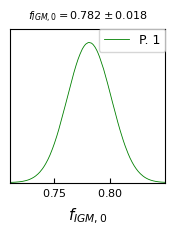

In [14]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples1.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples1, filled=True, contour_colors=['green'], 
                legend_labels=['P. 1'], 
                title_limit=1)
g.export('Figuras/H_p1.png', dpi=600)

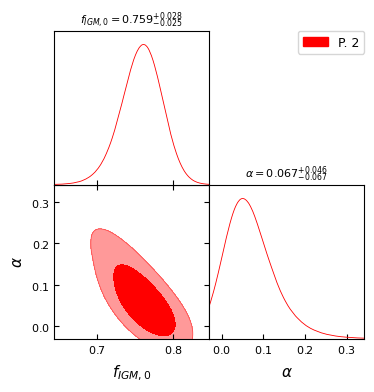

In [15]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples2.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples2, filled=True, contour_colors=['red'],
                legend_labels=['P. 2'], title_limit=1)
g.export('Figuras/H_p2.png', dpi=600)

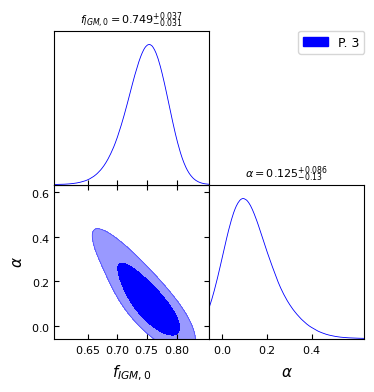

In [16]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples3.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples3, filled=True, contour_colors=['blue'],
                legend_labels=['P. 3'], title_limit=1)
g.export('Figuras/H_p3.png', dpi=600)

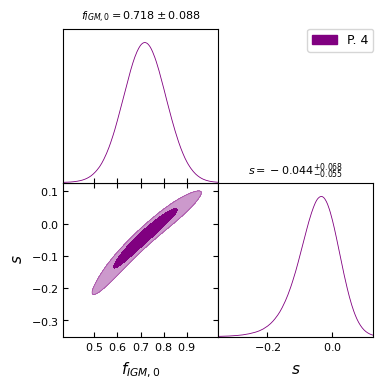

In [17]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples4.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples4, filled=True, contour_colors=['purple'],
                legend_labels=['P. 4'], title_limit=1)
g.export('Figuras/H_p4.png', dpi=600)

TypeError: H_Model.H_p() missing 2 required positional arguments: 'param' and 'model_type'

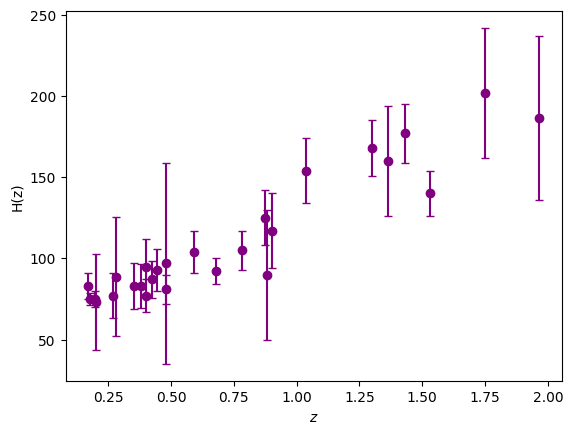

In [20]:
from ultranest.plot import PredictionBand
from equations import H_Model

plt.figure()
plt.xlabel('$z$')
plt.ylabel('H(z)')
plt.errorbar(x=z_values, y=H_obs, yerr=errors, marker='o', capsize=3, ls=' ', color='purple', label='$DM_{ext}^{obs}$')

band = PredictionBand(z_test.flatten())

# go through the solutions
for f_IGM  in sampler_constant.results['samples']:
    # compute for each time the y value
    model = H_Model()
    band.add(model.H_p(z_test.flatten(), f_IGM=f_IGM))

band.line(color='k', linestyle='--', label='$H_{P1}$', linewidth=1.5)
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

plt.legend()
plt.savefig('Figuras/H_bestfit.png', format='png', dpi=600)